<a href="https://colab.research.google.com/github/maheshbabu-r/BIG_DATA/blob/main/Working_With_Missing_and_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd
!ls
!python --version

/content
sample_data
Python 3.7.11


In [2]:
# for suppress warnings
# python packages
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz  # supress download output use -q

!tar -zxvf spark-3.1.2-bin-hadoop3.2.tgz | grep "something" 2>/dev/null #Suppress tar output ---| grep "something" 2>/dev/null--- add after file_name"

!pip -q install findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext

from pyspark.sql.functions import approx_count_distinct,collect_list
from pyspark.sql.functions import collect_set,sum,avg,max,countDistinct,count
from pyspark.sql.functions import first, last, kurtosis, min, mean, skewness 
from pyspark.sql.functions import stddev, stddev_samp, stddev_pop, sumDistinct
from pyspark.sql.functions import variance,var_samp,  var_pop

# or import like this
from pyspark.sql.functions import *

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("PySpark 3.0 Setup on Google Colab").getOrCreate()
print(spark.sparkContext.appName)

pyspark-shell


In [5]:
!wget -q https://raw.githubusercontent.com/maheshbabu-r/BIG_DATA/main/Hadoop%20Datasets/weatherdata.csv

In [6]:
# load Data into Pyspark Dataframe

df=spark.read.csv(header=True,inferSchema=True,path="/content/weatherdata.csv")

df.printSchema()

df.show(5)

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|         44.0|
|2008-12-02|  Albury|    7.4|   25.1|     0.0|       null|    null|        WNW|         44.0|
|2008-12-03|  Albury|   12.9|   25.7|     0.0|       null|    null|        WSW|         46.0|
|2008-12-04|  Albury|    9.2|   28.0|     0.0|       null|    nul

In [7]:
# it takes all the columns no matter about the data types and no median value included
df.describe().show()

+-------+----------+--------+------------------+-----------------+-----------------+-----------------+------------------+-----------+------------------+
|summary|      Date|Location|           MinTemp|          MaxTemp|         Rainfall|      Evaporation|          Sunshine|WindGustDir|     WindGustSpeed|
+-------+----------+--------+------------------+-----------------+-----------------+-----------------+------------------+-----------+------------------+
|  count|    142193|  142193|            141556|           141871|           140787|            81350|             74377|     132863|            132923|
|   mean|      null|    null|12.186399728729217|23.22678419127246|2.349974074311104|5.469824216349112| 7.624853113193588|       null| 39.98429165757619|
| stddev|      null|    null| 6.403282674671329|7.117618141018117|8.465172917616421|4.188536508895161|3.7815249942144558|       null|13.588800765487802|
|    min|2007-11-01|Adelaide|              -8.5|             -4.8|              0.

In [8]:
# check column wise data types 
df.dtypes

[('Date', 'string'),
 ('Location', 'string'),
 ('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('Evaporation', 'double'),
 ('Sunshine', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'double')]

In [9]:
# to check single column stats using describe
df.describe("MaxTemp").show()

+-------+-----------------+
|summary|          MaxTemp|
+-------+-----------------+
|  count|           141871|
|   mean|23.22678419127246|
| stddev|7.117618141018117|
|    min|             -4.8|
|    max|             48.1|
+-------+-----------------+



In [10]:
# to check multiple columns stats using describe
df.describe(["MaxTemp","MinTemp"]).show()

+-------+-----------------+------------------+
|summary|          MaxTemp|           MinTemp|
+-------+-----------------+------------------+
|  count|           141871|            141556|
|   mean|23.22678419127246|12.186399728729217|
| stddev|7.117618141018117| 6.403282674671329|
|    min|             -4.8|              -8.5|
|    max|             48.1|              33.9|
+-------+-----------------+------------------+



In [11]:
# here pyspark is important to check data distribution for median values included
df.summary().show()

+-------+----------+--------+------------------+-----------------+-----------------+-----------------+------------------+-----------+------------------+
|summary|      Date|Location|           MinTemp|          MaxTemp|         Rainfall|      Evaporation|          Sunshine|WindGustDir|     WindGustSpeed|
+-------+----------+--------+------------------+-----------------+-----------------+-----------------+------------------+-----------+------------------+
|  count|    142193|  142193|            141556|           141871|           140787|            81350|             74377|     132863|            132923|
|   mean|      null|    null|12.186399728729217|23.22678419127246|2.349974074311104|5.469824216349112| 7.624853113193588|       null| 39.98429165757619|
| stddev|      null|    null| 6.403282674671329|7.117618141018117|8.465172917616421|4.188536508895161|3.7815249942144558|       null|13.588800765487802|
|    min|2007-11-01|Adelaide|              -8.5|             -4.8|              0.

In [12]:
# we can use all the pandas fuctions using toPandas() function on pyspark data frame
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
dtypes: float64(6), object(3)
memory usage: 9.8+ MB


In [13]:
# to check percentage of null values with respect to each column
df.toPandas().isna().mean().round(4) * 100

Date              0.00
Location          0.00
MinTemp           0.45
MaxTemp           0.23
Rainfall          0.99
Evaporation      42.79
Sunshine         47.69
WindGustDir       6.56
WindGustSpeed     6.52
dtype: float64

In [15]:
# drop morethan 40% missing values related columns
df=df.drop('Sunshine','Evaporation')

In [16]:
df.show(3)

+----------+--------+-------+-------+--------+-----------+-------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|
+----------+--------+-------+-------+--------+-----------+-------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|          W|         44.0|
|2008-12-02|  Albury|    7.4|   25.1|     0.0|        WNW|         44.0|
|2008-12-03|  Albury|   12.9|   25.7|     0.0|        WSW|         46.0|
+----------+--------+-------+-------+--------+-----------+-------------+
only showing top 3 rows



In [17]:
# to get specific value in column using index and column name
df.collect()[1]["MaxTemp"]

25.1

In [18]:
df.select("MinTemp").summary().show()

+-------+------------------+
|summary|           MinTemp|
+-------+------------------+
|  count|            141556|
|   mean|12.186399728729217|
| stddev| 6.403282674671329|
|    min|              -8.5|
|    25%|               7.6|
|    50%|              12.0|
|    75%|              16.8|
|    max|              33.9|
+-------+------------------+



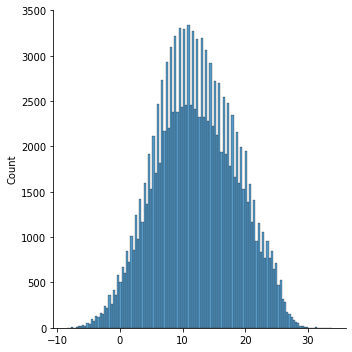

In [19]:
sns.displot(df.toPandas()["MinTemp"].values.tolist());

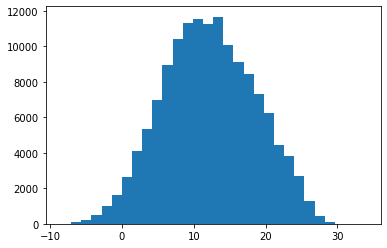

In [20]:
plt.hist(df.toPandas()["MinTemp"].values.tolist(),bins=30)
plt.show()

In [21]:
avg_min_temp=df.select("MinTemp").agg(mean("MinTemp").alias("Avg_Min_temp")).first()[0]

print(avg_min_temp)

df=df.na.fill({"MinTemp":avg_min_temp})

12.186399728729217


In [22]:
df.toPandas().isna().mean().round(4) * 100

Date             0.00
Location         0.00
MinTemp          0.00
MaxTemp          0.23
Rainfall         0.99
WindGustDir      6.56
WindGustSpeed    6.52
dtype: float64

+-------+-----------------+
|summary|          MaxTemp|
+-------+-----------------+
|  count|           141871|
|   mean|23.22678419127246|
| stddev|7.117618141018117|
|    min|             -4.8|
|    25%|             17.9|
|    50%|             22.6|
|    75%|             28.2|
|    max|             48.1|
+-------+-----------------+



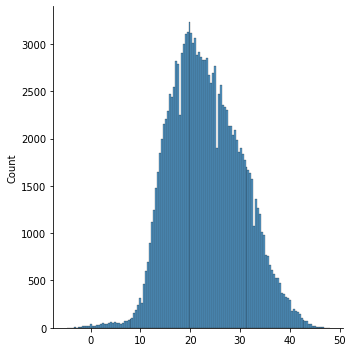

In [23]:
df.select("MaxTemp").summary().show()
sns.displot(df.toPandas()["MaxTemp"].values.tolist());

In [24]:
avg_max_temp=df.select("MaxTemp").summary().collect()[5]["MaxTemp"]

print(avg_max_temp)

df=df.na.fill({"MaxTemp":avg_min_temp})

22.6


In [25]:
df.toPandas().isna().mean().round(4) * 100

Date             0.00
Location         0.00
MinTemp          0.00
MaxTemp          0.00
Rainfall         0.99
WindGustDir      6.56
WindGustSpeed    6.52
dtype: float64

+-------+-----------------+
|summary|         Rainfall|
+-------+-----------------+
|  count|           140787|
|   mean|2.349974074311104|
| stddev|8.465172917616421|
|    min|              0.0|
|    25%|              0.0|
|    50%|              0.0|
|    75%|              0.8|
|    max|            371.0|
+-------+-----------------+



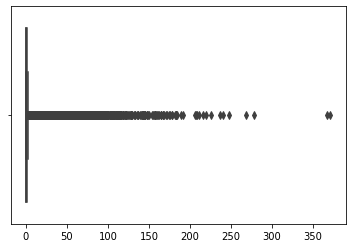

In [26]:
df.select("Rainfall").summary().show()
sns.boxplot(df.toPandas()["Rainfall"].values.tolist())
plt.show()

In [27]:
df=df.na.fill({"Rainfall":0})

In [28]:
df.toPandas().isna().mean().round(4) * 100

Date             0.00
Location         0.00
MinTemp          0.00
MaxTemp          0.00
Rainfall         0.00
WindGustDir      6.56
WindGustSpeed    6.52
dtype: float64

In [29]:
df.toPandas()["WindGustDir"].value_counts()

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64

In [30]:
mode=df.toPandas()["WindGustDir"].value_counts().index[0]

mode

'W'

In [31]:
df=df.na.fill({"WindGustDir":mode})

In [32]:
df.toPandas().isna().mean().round(4) * 100

Date             0.00
Location         0.00
MinTemp          0.00
MaxTemp          0.00
Rainfall         0.00
WindGustDir      0.00
WindGustSpeed    6.52
dtype: float64

+-------+------------------+
|summary|     WindGustSpeed|
+-------+------------------+
|  count|            132923|
|   mean| 39.98429165757619|
| stddev|13.588800765487802|
|    min|               6.0|
|    25%|              31.0|
|    50%|              39.0|
|    75%|              48.0|
|    max|             135.0|
+-------+------------------+



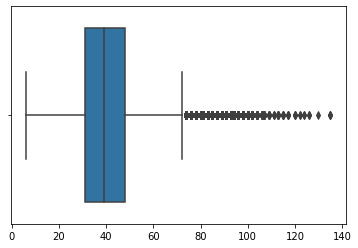

In [33]:
df.select("WindGustSpeed").summary().show()
sns.boxplot(df.toPandas()["WindGustSpeed"].values.tolist())
plt.show()

In [34]:
df=df.na.fill({"WindGustSpeed":df.toPandas()["WindGustSpeed"].mean()})
df.toPandas().isna().mean().round(4) * 100

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
dtype: float64

In [35]:
df.count()

142193

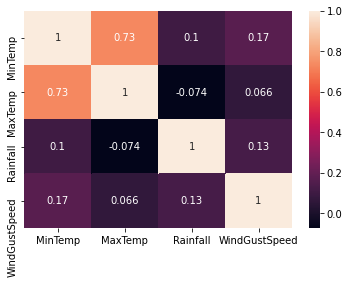

In [36]:
sns.heatmap(df.toPandas().corr(),annot=True)
plt.show()

In [38]:
# For downloading the dataset
# Go to Kaggle.com -> My Account -> Create new API Token -> Upload kaggle.json in Jupyter Home/CNN/

!wget -q https://raw.githubusercontent.com/maheshbabu-r/BIG_DATA/main/Hadoop%20Datasets/kaggle.json

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json
!kaggle datasets download -d epattaro/brazils-house-of-deputies-reimbursements
!unzip /content/brazils-house-of-deputies-reimbursements.zip

 41% 14.0M/34.2M [00:00<00:00, 145MB/s]
100% 34.2M/34.2M [00:00<00:00, 168MB/s]
Archive:  /content/brazils-house-of-deputies-reimbursements.zip
  inflating: deputies_dataset.csv    
  inflating: dirty_deputies_v2.csv   


In [39]:
out=spark.read.csv(header=True,inferSchema=True,path="/content/dirty_deputies_v2.csv")

out.printSchema()
out.show(5)

root
 |-- deputy_name: string (nullable = true)
 |-- deputy_state: string (nullable = true)
 |-- political_party: string (nullable = true)
 |-- refund_description: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_id: double (nullable = true)
 |-- refund_date: timestamp (nullable = true)
 |-- refund_value: double (nullable = true)
 |-- party_pg: string (nullable = true)
 |-- party_en: string (nullable = true)
 |-- party_tse: string (nullable = true)
 |-- party_regdate: string (nullable = true)
 |-- party_nmembers: string (nullable = true)
 |-- party_ideology1: string (nullable = true)
 |-- party_ideology2: string (nullable = true)
 |-- party_ideology3: string (nullable = true)
 |-- party_ideology4: string (nullable = true)
 |-- party_position: string (nullable = true)

+--------------------+------------+---------------+------------------+--------------------+----------------+-------------------+------------+----------+---------+---------+-------------+--

In [40]:
out.select("refund_value").summary().show()

+-------+-----------------+
|summary|     refund_value|
+-------+-----------------+
|  count|           339089|
|   mean|625.7474209720527|
| stddev|2076.983477144462|
|    min|          -6100.0|
|    25%|             50.0|
|    50%|            150.0|
|    75%|            506.0|
|    max|         184500.0|
+-------+-----------------+



In [41]:
Median=out.select("refund_value").summary().collect()[5]["refund_value"]

Q1=out.select("refund_value").summary().collect()[4]["refund_value"]

Q3=out.select("refund_value").summary().collect()[6]["refund_value"]

print("Q1 :%a"%Q1)

print("Q3 :%a"%Q3)

IQR=float(Q3)-float(Q1)


print("IQR :%a"%IQR)

lower_extreme=float(Q1)-(1.5*IQR)


print("lower extreme :%a"%lower_extreme)

upper_extreme=float(Q3)+(1.5*IQR)

print("upper_extreme :%a"%upper_extreme)



Q1 :'50.0'
Q3 :'506.0'
IQR :456.0
lower extreme :-634.0
upper_extreme :1190.0


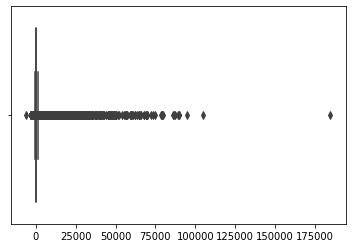

In [42]:
sns.boxplot(out.toPandas()["refund_value"].values.tolist())
plt.show()

In [43]:
out=out.withColumn("refund_value1", when(out.refund_value < -634, -634)\
               .when(out.refund_value> 1190.0, 1190.0)\
               .otherwise(out.refund_value))
out=out.drop("refund_value")

out.withColumnRenamed("refund_value1","refund_value")

DataFrame[deputy_name: string, deputy_state: string, political_party: string, refund_description: string, company_name: string, company_id: double, refund_date: timestamp, party_pg: string, party_en: string, party_tse: string, party_regdate: string, party_nmembers: string, party_ideology1: string, party_ideology2: string, party_ideology3: string, party_ideology4: string, party_position: string, refund_value: double]

In [44]:
out.printSchema()

root
 |-- deputy_name: string (nullable = true)
 |-- deputy_state: string (nullable = true)
 |-- political_party: string (nullable = true)
 |-- refund_description: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_id: double (nullable = true)
 |-- refund_date: timestamp (nullable = true)
 |-- party_pg: string (nullable = true)
 |-- party_en: string (nullable = true)
 |-- party_tse: string (nullable = true)
 |-- party_regdate: string (nullable = true)
 |-- party_nmembers: string (nullable = true)
 |-- party_ideology1: string (nullable = true)
 |-- party_ideology2: string (nullable = true)
 |-- party_ideology3: string (nullable = true)
 |-- party_ideology4: string (nullable = true)
 |-- party_position: string (nullable = true)
 |-- refund_value1: double (nullable = true)



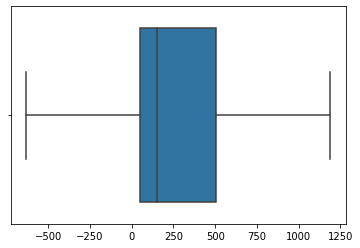

In [45]:
sns.boxplot(out.toPandas()["refund_value1"].values.tolist())
plt.show()